# Don't make a racist machine!: notes on bias and cleanX

cleanX is a code library meant for data cleaning of certain radiological images in preparation for algorithm creation. Some features it has may be particularly useful are the ability to seperate data by sensitive category, and check resolution...Let's see an example. I'll make an example out of an augmented dataset which will include race and gender:

In [1]:
# libraries
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os 

import shutil
import PIL
from PIL import Image, ImageOps
from cleanX import (
    dataset_processing as csvp,
    # dicom_processing as dicomp,
    image_work as iwork,
)

In [2]:

example_path = "martians_2051.csv"
example = pd.read_csv(example_path)
example

Unnamed: 0            X_ray_image_name     Label Dataset_type  \
0              0           IM-0128-0001.jpeg    Normal        TRAIN   
1              1           IM-0127-0001.jpeg    Normal        TRAIN   
2              2           IM-0125-0001.jpeg    Normal        TRAIN   
3              3           IM-0122-0001.jpeg    Normal        TRAIN   
4              4           IM-0119-0001.jpeg    Normal        TRAIN   
...          ...                         ...       ...          ...   
5905        5905  person1637_virus_2834.jpeg  Pnemonia         TEST   
5906        5906  person1635_virus_2831.jpeg  Pnemonia         TEST   
5907        5907  person1634_virus_2830.jpeg  Pnemonia         TEST   
5908        5908  person1633_virus_2829.jpeg  Pnemonia         TEST   
5909        5909  person1632_virus_2827.jpeg  Pnemonia         TEST   

     Label_2_Virus_category Label_1_Virus_category  gender           race  
0                       NaN                    NaN    Male  white martian  
1                       NaN                    NaN  Female  black martian  
2                       NaN                    NaN  Female  white martian  
3                       NaN                    NaN    Male  black martian  
4                       NaN                    NaN  Female  white martian  
...                     ...                    ...     ...            ...  
5905                    NaN                  Virus    Male  black martian  
5906                    NaN                  Virus  Female  white martian  
5907                    NaN                  Virus  Female  black martian  
5908                    NaN                  Virus    Male  white martian  
5909                    NaN                  Virus  Female  black martian  

[5910 rows x 8 columns]

## This is not a real world example...let's imagine it's literally not from this world, but rather a future on Mars

In [3]:
bias_checker = csvp.see_part_potential_bias(example,"Label", ["gender","race"])
bias_checker

sums
Label    gender race                   
Normal   Female black martian       526
                white martian       525
         Male   asian martian         1
                black martian       260
                plutonian martian     1
                purple martian        1
                white martian       262
Pnemonia Female black martian      1444
                venusian martian      1
                white martian      1445
         Male   black martian       723
                white martian       721

Where are all the Native American martians in my dataset? No Latino martians and  a single Asian martian? Does not seem like the real world...Seems like we may be set up for some wacky bias. In the real world depending upon our case, we might need to get more data. But let's pretend we only want to look at black and white martians now, for an academic exercise.

A note on the images and path:
We will use the CoronaHack -Chest X-Ray-Dataset from Kaggle (https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset). The dataset was assembled by Praveen Govindaraj. This dataset has thousands of images ( 5,309 images to be exact)...too many to look through by hand without wasting a lot of time

Unfortunately, keeping 40 gigabytes of image data on Github is not possible or a good idea. If you want to get these images onto your computer, you basically need tosign into Kaggle, and download. There is no way to download without credentials at present.


In [4]:
# here I pull the images off my drive 
# you will need to substitute your own download adress
# to be updated with download instructions cell
path ='D:/my_academia/ncs/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/'    

In [5]:
# black martians had a slightly higher number of images, but what about quality? 
# a technnical note this will only work if you have all the images listed
quality_list =[]
# path = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/"

for value in example.X_ray_image_name:
    try:
        image = cv2.imread(os.path.join(path,value))
        string = os.path.join(path,value)
        quality_score = iwork.image_quality_by_size(string)
    except: 
        quality_score = 0
    quality_list.append(quality_score)
    
example['q_score'] = quality_list    

In [6]:
# now on mars and black and white people getting the same quality
# of imaging if we judge by resolution? let's look by sensitive category
black_q_total =example.q_score[example.race == 'black martian'].sum()
black_count_total =example.q_score[example.race == 'black martian'].count()
avg_q_black= black_q_total/black_count_total
avg_q_black

205355.30172705723

In [7]:
white_q_total =example.q_score[example.race == 'white martian'].sum()
white_count_total =example.q_score[example.race == 'white martian'].count()
avg_q_white= white_q_total/white_count_total
avg_q_white

201324.04097527938

In [8]:
# SO let's look at the ratio...even though we can see the numbers are close
avg_q_black/avg_q_white

1.020023742481271

## Here is where we seperate the pro data analysts from the children:
An average is NOT all you need. Take a peak at the distributions, to make sure they are not hiding anyting (like one single super high quality black martian image and almost all of low quality)

In [9]:
black_martians = example[example.race == 'black martian']
white_martians = example[example.race == 'white martian']
#black_martians.q_score.hist(bins = 20)

In [10]:
#white_martians.q_score.hist(bins =20)

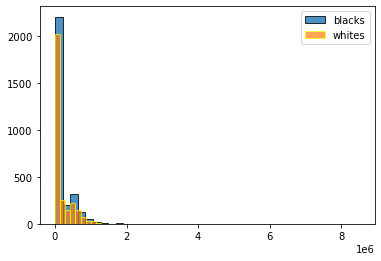

In [11]:
plt.hist(black_martians.q_score, label='blacks', alpha=.8, edgecolor='black', bins = 40)
  
# plotting second histogram
plt.hist(white_martians.q_score, label='whites', alpha=0.7, edgecolor='yellow', bins = 40)
plt.legend()

## OK, so our dataset seems fine for black and white martians, but lacks diversity. 
Get more data, especially
on plutonian and Latino martians...

# Meanwhile back on planet earth: 
Usually the quality if images is going with socioeconomic status, which in multi-cultural socieities may correlate with ethnicty and/or race...watch out. In all seriousness you can think of AI as having an alien brain that sees very differently from humans. This alien brain can pick up all kinds of correlations without causality. Correlations are not random, but may reflect social biases and problems. For example, women with less access to high quality healthcare and lower socioeconomic status may recieve lower quality screening mammography (judging by parameters like compression) read by less qualified physicians. 
We must be very careful not to encode bias against people with less access to high quality radiology into out AI work. 

You can learn more about cleanX's other functions in the other notebooks [here](https://github.com/drcandacemakedamoore/cleanX/blob/main/workflow_demo/no_classes_workflow_example.ipynb) and [here](https://github.com/drcandacemakedamoore/cleanX/blob/main/workflow_demo/classes_workflow.ipynb).